# SynthDet Evaluation

This notebook is for the model prediction visualization. You can load your model and visualize predicted bounding boxes for the GroceriesReal validation dataset. This notebook would show you the performance metrics (mAP, mAP@IOU50, mAR@100) for your model based on GroceriesReal test dataset. Also, this notebook can analyze the easy and hard cases from the point of view of the model. This would provide a better understanding about how to minimize sim2real gaps or improve model performance.<br>
You can use this notebook by the following steps:
- Specify the model path. Then, the notebook would load the checkpoints into a `FasterRCNN` estimator. The `FasterRCNN` can provide model predictions.
- Provide the model performance metrics.
- Can either specify or randomly select some cases for the visualization.

## Settings
Specify your settings down below

In [1]:
# local data path to save downloaded dataset:
# Why do we need this setting?

# switch to this default path to allow user running inside docker container
# data_root = "/data"
data_root = "/Users/bowen.li/data/"

Specify a pre-trained model that can be used to calculate model performance as well as prediction visualization. You can use one of the model that we pre-trained or use the model that you have trained. 

In [2]:
# 1. Real-trained estimator on 760 images
# estimator_path = "https://storage.googleapis.com/datasetinsights/models/Real-World/FasterRCNN.estimator"

# 2. Synth-trained estimator on 400K SynthDet dataset
# estimator_path = "https://storage.googleapis.com/datasetinsights/models/Synthetic/FasterRCNN.estimator"

# 3. Fine-tuned estimator (pre-trained on 400K Synthetic data and fine-tuned on 76 images)
# estimator_path = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-76-images/FasterRCNN.estimator"

# 4. Fine-tuned estimator (pre-trained on 400K Synthetic data and fine-tuned on 380 images)
# estimator_path = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-380-images/FasterRCNN.estimator"

# 5. Fine-tuned estimator (pre-trained on 400K Synthetic data and fine-tuned on 760 images)
# This is the estimator that provide the best result.
estimator_path = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-760-images/FasterRCNN.estimator"

# How to download the model that they have stored on GCS

In [10]:
# estimator_path = "gs://"

## Download GroceriesReal Dataset
Download GrocereisReal data. You only need to download the data once.

In [3]:
# You only need to download the data once.
# change this variable once we have public groceries real dataset name
import os
from datasetinsights.io import create_downloader

data_path = os.path.join(data_root, "groceries", "v3")

def download_dataset():
    groceries_real_source_uri = "https://storage.googleapis.com/datasetinsights/data/groceries/v3.zip"
    downloader = create_downloader(source_uri=groceries_real_source_uri)
    downloader.download(source_uri=groceries_real_source_uri, output=data_path, include_binary=True)

# uncomment this
# download_dataset()

## Load Model

In [4]:
import tempfile
from yacs.config import CfgNode as CN
from datasetinsights.estimators import create_estimator

def estimator_config():
    config_yaml = """
        estimator: FasterRCNN
        backbone: resnet50
        num_classes: 64
        task: object_detection
        test:
          batch_size: 8
          dataset:
            name: GroceriesReal
            args:
              version: v3
              split: test
        metrics:
          mAP:
            name: MeanAveragePrecisionAverageOverIOU
          mAPIOU50:
            name: MeanAveragePrecisionIOU50
          mAR:
            name: MeanAverageRecallAverageOverIOU
        pretrained: False
        pretrained_backbone: True
        synchronize_metrics: True
    """
    config = CN.load_cfg(config_yaml)
    
    return config

def load_estimator(checkpoint_file):  
    config = estimator_config()

    estimator = create_estimator(
        name=config.estimator,
        config=config,
        checkpoint_dir = tempfile.TemporaryDirectory().name,
        checkpoint_file=checkpoint_file,
        kfp_metrics_dir = tempfile.TemporaryDirectory().name,
    )

    return estimator

estimator = load_estimator(estimator_path)

## Model performance metrics
This section would show you the model performance on GroceriesReal test dataset. You would see:

We report three evaluation metrics that's commonly used for object detection task
- [mAP](https://datasetinsights.readthedocs.io/en/latest/datasetinsights.evaluation_metrics.html#datasetinsights.evaluation_metrics.average_precision_2d.MeanAveragePrecisionAverageOverIOU): Average Precision average over all labels and IOU thresholds = 0.5:0.95:0.05
- [mAPIOU50](https://datasetinsights.readthedocs.io/en/latest/datasetinsights.evaluation_metrics.html#datasetinsights.evaluation_metrics.average_precision_2d.MeanAveragePrecisionIOU50): Mean Average Precision at IOU=50%.
- [mAR](https://datasetinsights.readthedocs.io/en/latest/datasetinsights.evaluation_metrics.html#datasetinsights.evaluation_metrics.average_recall_2d.MeanAverageRecallAverageOverIOU): Average Recall average over all labels and IOU thresholds = 0.5:0.95:0.05

In [ ]:
# This step will take a while (1 hour) if you run it locally as it will go through the whole test dataset and make predictions.
# It will be rougly 3-5 min on GPU...
estimator.model.eval()
estimator.evaluate(data_path)

In [ ]:
import pandas as pd

metric_name = ["mAP", "mAPIOU50", "mAR"]
metrics = estimator.metrics
df = pd.DataFrame({
    "metric_name": metric_name,
    "metric_value": [metrics[name].compute() for name in metric_name]
})
df

## Model Prediction Visualization

Use the loaded model to predict on GroceriesReal Validation Dataset. We highlight predicted bounding boxes into 2 colors:
- <font color='green'>Green boxes</font>: it's a correct predicted label and overlap the true box enough (overlap >= 0.5). <br>
- <font color='red'>Red boxes</font>: it's a wrong prediction.<br>

In [6]:
from datasetinsights.datasets import Dataset
test_dataset = Dataset.create(
    "GroceriesReal",
    data_path=data_path,
    split="test",
)

In [7]:
from datasetinsights.stats.visualization.plots import match_boxes, plot_bboxes
from datasetinsights.stats import grid_plot
def visualize_predictions(estimator, dataset, index):
    # keep in notebook
    pil_image, gt_bboxes = dataset[index]
    pred_bboxes = estimator.predict(pil_image, box_score_thresh=0.5)
    colors = match_boxes(pred_bboxes, gt_bboxes)
    gt_plot = plot_bboxes(pil_image, gt_bboxes, dataset.label_mappings)
    pred_plot = plot_bboxes(pil_image, pred_bboxes, dataset.label_mappings, colors)
    
    titles = [
        f"ground truth for Image {index + 1}",
        f"model prediction for Image {index + 1}",
    ]
    grid_plot([[gt_plot, pred_plot]], figsize=(7, 10), img_type="rgb", titles=titles)

**Predictions for some user-selected or randomly-selected cases** <br>
You can specify some cases or randomly select K cases. For each image, there are two plots:
- The left one is the ground truth image. <br>
- The right one is the model prediction.<br>

In [8]:
import numpy as np
# specify image_indicies if you want to visualize a particular set of images
# image_indicies = [0, 1, 2]
K = 3
image_indicies = sorted(np.random.randint(0, len(test_dataset) - 1, size=K))

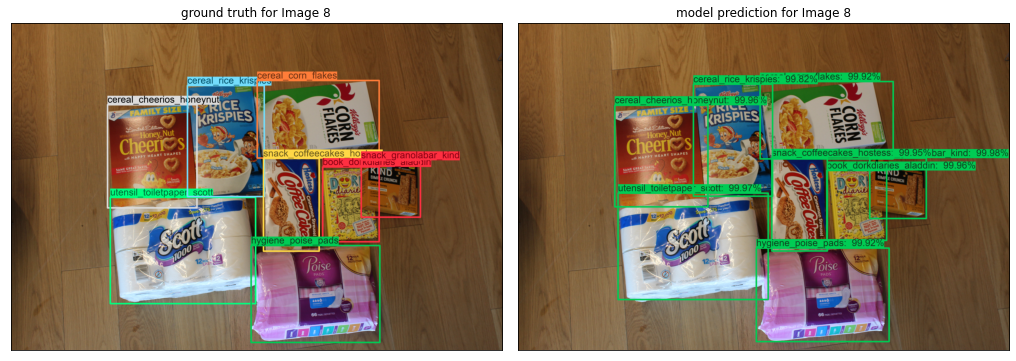

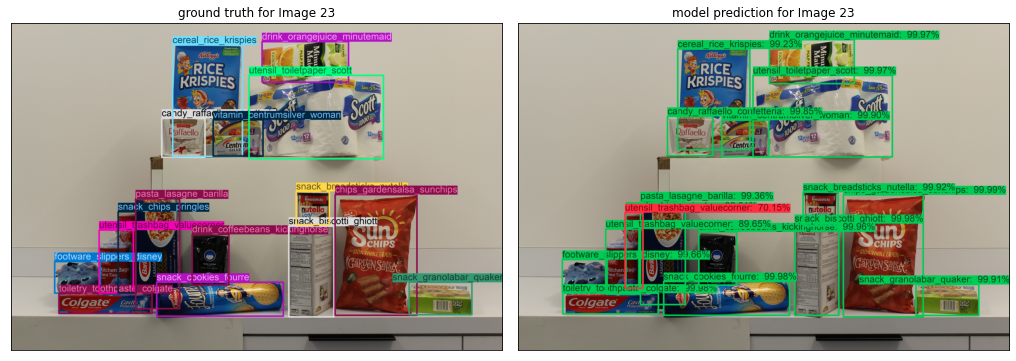

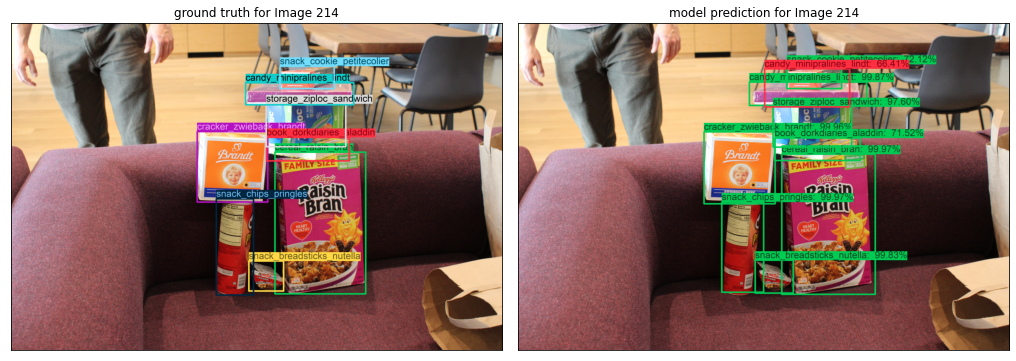

In [9]:
for index in image_indicies:
    visualize_predictions(estimator, test_dataset, index)